# Advance Traffic Management System

## Contributers

### Aloukik Aditya
### Rishabh Mittal
### Sachin Gupta
### Shobhit Gupta

### Binarization

We propose a novel method for binarization of color documents whereby the foreground text is output as black and the background as white regardless of the polarity of foreground-background shades. The method employs an edge-based connected component approach and automatically determines a threshold for each component. It has several advantages over existing binarization methods. Firstly, it can handle documents with multi-colored texts with different background shades. Secondly, the method is applicable to documents having text of widely varying sizes, usually not handled by local binarization methods. Thirdly, the
method automatically computes the threshold for binarization and the logic for inverting the output from the image data and does not require any input parameter.


Input File


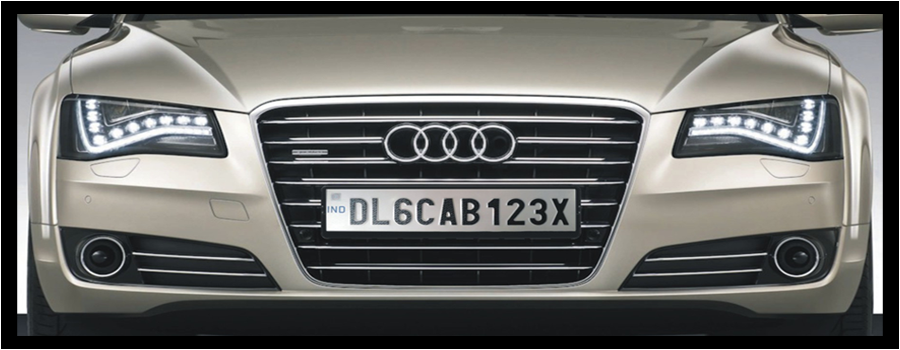

Binarized File


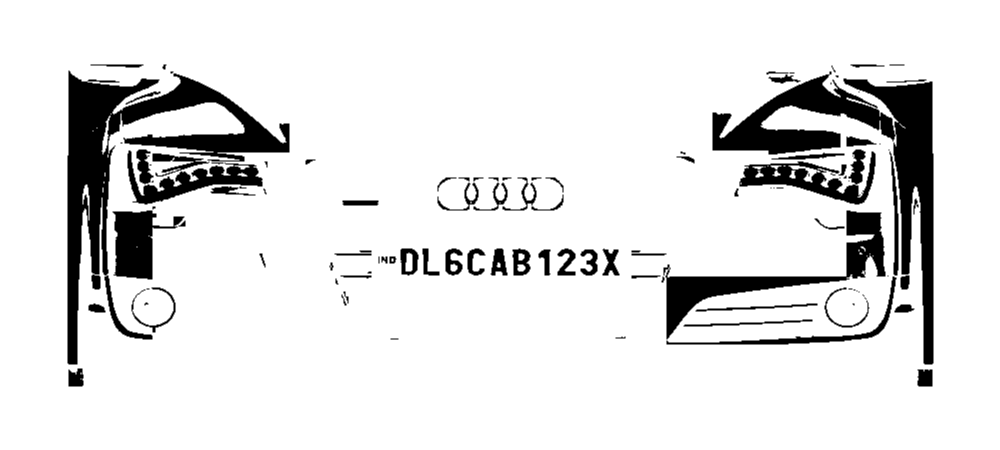


Input File


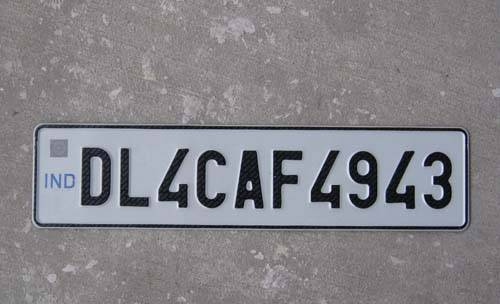

Binarized File


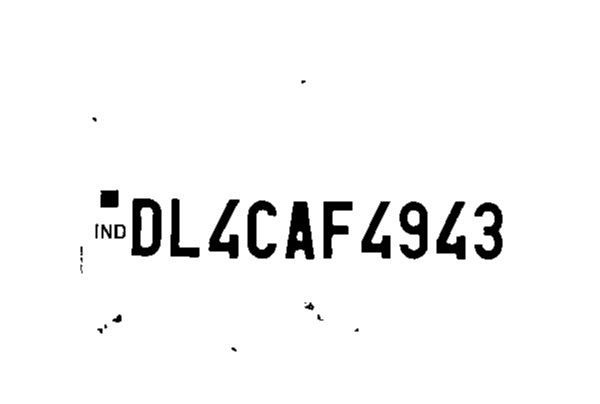


Input File


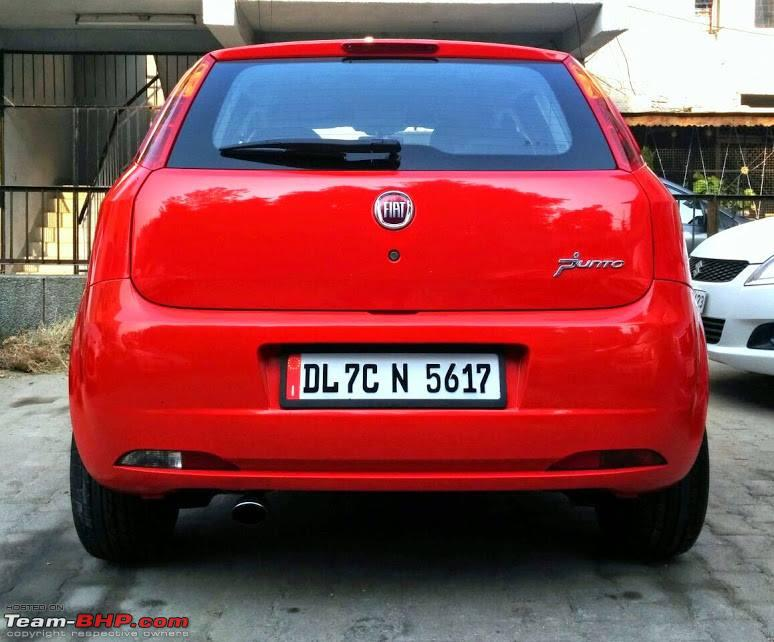

Binarized File


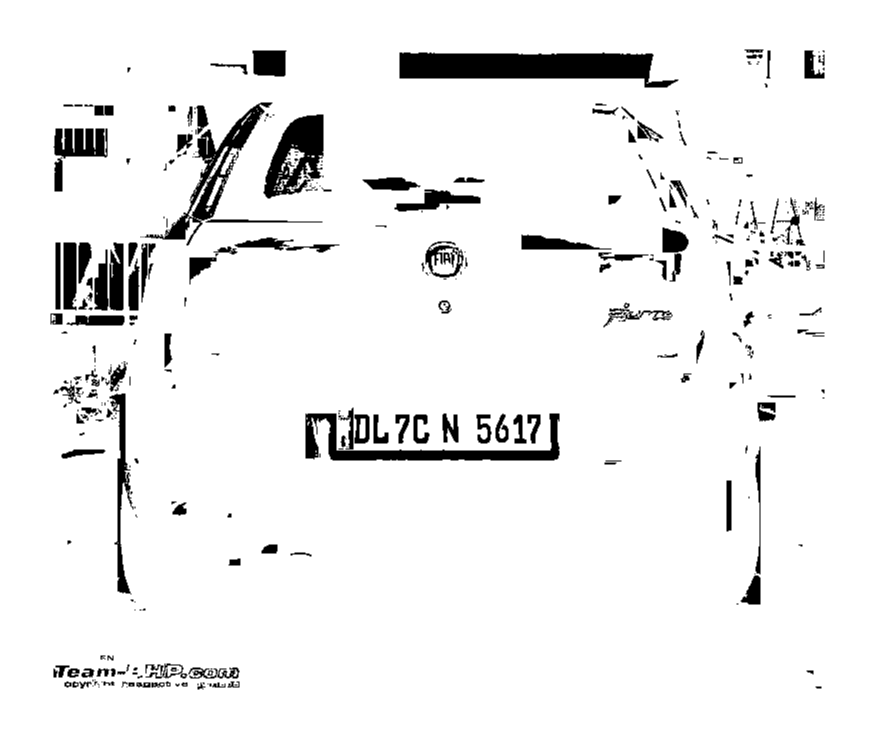

In [2]:
import cv2
import numpy as np
import sys
import os.path

'''
if len(sys.argv) != 3:
    print "%s input_file output_file" % (sys.argv[0])
    sys.exit()
else:
    input_file = sys.argv[1]
    output_file = sys.argv[2]
'''
input_file = "sample2.png"
output_file = "output.png"
    
if not os.path.isfile(input_file):
    print "No such file '%s'" % input_file
    sys.exit()



DEBUG = 0


# Determine pixel intensity
# Apparently human eyes register colors differently.
# TVs use this formula to determine
# pixel intensity = 0.30R + 0.59G + 0.11B
def ii(xx, yy):
    global img, img_y, img_x
    if yy >= img_y or xx >= img_x:
        #print "pixel out of bounds ("+str(y)+","+str(x)+")"
        return 0
    pixel = img[yy][xx]
    return 0.30 * pixel[2] + 0.59 * pixel[1] + 0.11 * pixel[0]


# A quick test to check whether the contour is
# a connected shape
def connected(contour):
    first = contour[0][0]
    last = contour[len(contour) - 1][0]
    return abs(first[0] - last[0]) <= 1 and abs(first[1] - last[1]) <= 1


# Helper function to return a given contour
def c(index):
    global contours
    return contours[index]


# Count the number of real children
def count_children(index, h_, contour):
    # No children
    if h_[index][2] < 0:
        return 0
    else:
        #If the first child is a contour we care about
        # then count it, otherwise don't
        if keep(c(h_[index][2])):
            count = 1
        else:
            count = 0

            # Also count all of the child's siblings and their children
        count += count_siblings(h_[index][2], h_, contour, True)
        return count


# Quick check to test if the contour is a child
def is_child(index, h_):
    return get_parent(index, h_) > 0


# Get the first parent of the contour that we care about
def get_parent(index, h_):
    parent = h_[index][3]
    while not keep(c(parent)) and parent > 0:
        parent = h_[parent][3]

    return parent


# Count the number of relevant siblings of a contour
def count_siblings(index, h_, contour, inc_children=False):
    # Include the children if necessary
    if inc_children:
        count = count_children(index, h_, contour)
    else:
        count = 0

    # Look ahead
    p_ = h_[index][0]
    while p_ > 0:
        if keep(c(p_)):
            count += 1
        if inc_children:
            count += count_children(p_, h_, contour)
        p_ = h_[p_][0]

    # Look behind
    n = h_[index][1]
    while n > 0:
        if keep(c(n)):
            count += 1
        if inc_children:
            count += count_children(n, h_, contour)
        n = h_[n][1]
    return count


# Whether we care about this contour
def keep(contour):
    return keep_box(contour) and connected(contour)


# Whether we should keep the containing box of this
# contour based on it's shape
def keep_box(contour):
    xx, yy, w_, h_ = cv2.boundingRect(contour)

    # width and height need to be floats
    w_ *= 1.0
    h_ *= 1.0

    # Test it's shape - if it's too oblong or tall it's
    # probably not a real character
    if w_ / h_ < 0.1 or w_ / h_ > 10:
        if DEBUG:
            print "\t Rejected because of shape: (" + str(xx) + "," + str(yy) + "," + str(w_) + "," + str(h_) + ")" + \
                  str(w_ / h_)
        return False
    
    # check size of the box
    if ((w_ * h_) > ((img_x * img_y) / 5)) or ((w_ * h_) < 15):
        if DEBUG:
            print "\t Rejected because of size"
        return False

    return True


def include_box(index, h_, contour):
    if DEBUG:
        print str(index) + ":"
        if is_child(index, h_):
            print "\tIs a child"
            print "\tparent " + str(get_parent(index, h_)) + " has " + str(
                count_children(get_parent(index, h_), h_, contour)) + " children"
            print "\thas " + str(count_children(index, h_, contour)) + " children"

    if is_child(index, h_) and count_children(get_parent(index, h_), h_, contour) <= 2:
        if DEBUG:
            print "\t skipping: is an interior to a letter"
        return False

    if count_children(index, h_, contour) > 2:
        if DEBUG:
            print "\t skipping, is a container of letters"
        return False

    if DEBUG:
        print "\t keeping"
    return True

# Load the image
orig_img = cv2.imread(input_file)

# Add a border to the image for processing sake
img = cv2.copyMakeBorder(orig_img, 50, 50, 50, 50, cv2.BORDER_CONSTANT)

# Calculate the width and height of the image
img_y = len(img)
img_x = len(img[0])

if DEBUG:
    print "Image is " + str(len(img)) + "x" + str(len(img[0]))

#Split out each channel
blue, green, red = cv2.split(img)

# Run canny edge detection on each channel
blue_edges = cv2.Canny(blue, 200, 250)
green_edges = cv2.Canny(green, 200, 250)
red_edges = cv2.Canny(red, 200, 250)

# Join edges back into image
edges = blue_edges | green_edges | red_edges

# Find the contours
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

hierarchy = hierarchy[0]

if DEBUG:
    processed = edges.copy()
    rejected = edges.copy()

# These are the boxes that we are determining
keepers = []

# For each contour, find the bounding rectangle and decide
# if it's one we care about
for index_, contour_ in enumerate(contours):
    if DEBUG:
        print "Processing #%d" % index_

    x, y, w, h = cv2.boundingRect(contour_)

    # Check the contour and it's bounding box
    if keep(contour_) and include_box(index_, hierarchy, contour_):
        # It's a winner!
        keepers.append([contour_, [x, y, w, h]])
        if DEBUG:
            cv2.rectangle(processed, (x, y), (x + w, y + h), (100, 100, 100), 1)
            cv2.putText(processed, str(index_), (x, y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    else:
        if DEBUG:
            cv2.rectangle(rejected, (x, y), (x + w, y + h), (100, 100, 100), 1)
            cv2.putText(rejected, str(index_), (x, y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))

# Make a white copy of our image
new_image = edges.copy()
new_image.fill(255)
boxes = []

# For each box, find the foreground and background intensities
for index_, (contour_, box) in enumerate(keepers):

    # Find the average intensity of the edge pixels to
    # determine the foreground intensity
    fg_int = 0.0
    for p in contour_:
        fg_int += ii(p[0][0], p[0][1])

    fg_int /= len(contour_)
    if DEBUG:
        print "FG Intensity for #%d = %d" % (index_, fg_int)

    # Find the intensity of three pixels going around the
    # outside of each corner of the bounding box to determine
    # the background intensity
    x_, y_, width, height = box
    bg_int = \
        [
            # bottom left corner 3 pixels
            ii(x_ - 1, y_ - 1),
            ii(x_ - 1, y_),
            ii(x_, y_ - 1),

            # bottom right corner 3 pixels
            ii(x_ + width + 1, y_ - 1),
            ii(x_ + width, y_ - 1),
            ii(x_ + width + 1, y_),

            # top left corner 3 pixels
            ii(x_ - 1, y_ + height + 1),
            ii(x_ - 1, y_ + height),
            ii(x_, y_ + height + 1),

            # top right corner 3 pixels
            ii(x_ + width + 1, y_ + height + 1),
            ii(x_ + width, y_ + height + 1),
            ii(x_ + width + 1, y_ + height)
        ]

    # Find the median of the background
    # pixels determined above
    bg_int = np.median(bg_int)

    if DEBUG:
        print "BG Intensity for #%d = %s" % (index_, repr(bg_int))

    # Determine if the box should be inverted
    if fg_int >= bg_int:
        fg = 255
        bg = 0
    else:
        fg = 0
        bg = 255

        # Loop through every pixel in the box and color the
        # pixel accordingly
    for x in range(x_, x_ + width):
        for y in range(y_, y_ + height):
            if y >= img_y or x >= img_x:
                if DEBUG:
                    print "pixel out of bounds (%d,%d)" % (y, x)
                continue
            if ii(x, y) > fg_int:
                new_image[y][x] = bg
            else:
                new_image[y][x] = fg

# blur a bit to improve ocr accuracy
new_image = cv2.blur(new_image, (2, 2))
cv2.imwrite(output_file, new_image)

#from PIL import Image
#f = Image.open("output.png").show()

from IPython.display import Image, display


if DEBUG:
    cv2.imwrite('edges.png', edges)
    cv2.imwrite('processed.png', processed)
    cv2.imwrite('rejected.png', rejected)
    
    
print "\nInput File"
display(Image(filename = input_file))

print "Binarized File"
display(Image(filename=output_file)) 

### References
<br>
<br>

[1] T Kasar, J Kumar and A G Ramakrishnan, "T Kasar, J Kumar and A G Ramakrishnan", Medical Intelligence and Language Engineering Laboratory, Department of Electrical Engineering, Indian Institute of Science,Bangalore, INDIA<br>
http://www.m.cs.osakafu-u.ac.jp/cbdar2007/proceedings/papers/O1-1.pdf